In [8]:
from src.model import Transformer, TransformerConfig
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Expectation: should be able to predict the next word with 100% accuracy, except for the last word, where it should be undecided between "working" and "broken"
sentences = ["this transformer is working <end>", "this transformer is broken <end>"]
words = {"this": 0, "transformer": 1, "is": 2, "working": 3, "broken": 4, "<end>": 5}
training_data = torch.LongTensor([[words[word] for word in example.split(" ")] for example in sentences])
y = torch.LongTensor([[words[word] for word in example.split(" ")[1:]] + [words["<end>"]] for example in sentences]).view(-1)
print(training_data)
print(y)


tensor([[0, 1, 2, 3, 5],
        [0, 1, 2, 4, 5]])
tensor([1, 2, 3, 5, 5, 1, 2, 4, 5, 5])


In [4]:
one_hot_y = nn.functional.one_hot(y, num_classes=6).float()
transformer = Transformer(TransformerConfig(vocab_size=6, max_input_length=5, num_heads=2, num_blocks=2, embedding_size=16))
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(transformer.parameters(), lr=1e-4)

for i in range(10000):
    x = transformer(training_data)
    x = x.view(-1, x.shape[-1])
    loss = loss_fn(x, one_hot_y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if i%999 == 0:
        print(f"Step: {i}, loss: {loss}")

Step: 0, loss: 0.23561261594295502
Step: 999, loss: 0.09915817528963089
Step: 1998, loss: 0.0925896018743515
Step: 2997, loss: 0.09202101826667786
Step: 3996, loss: 0.09078829735517502
Step: 4995, loss: 0.06511389464139938
Step: 5994, loss: 0.06772378832101822
Step: 6993, loss: 0.020978396758437157
Step: 7992, loss: 0.02427392639219761
Step: 8991, loss: 0.01605958119034767
Step: 9990, loss: 0.02397342398762703


[[0.    0.998 0.001 0.    0.    0.   ]
 [0.    0.001 0.998 0.    0.    0.   ]
 [0.003 0.    0.014 0.501 0.477 0.004]
 [0.    0.    0.    0.    0.    1.   ]]


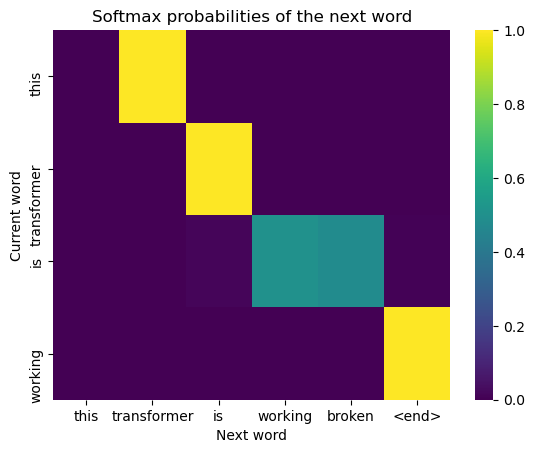

In [29]:
transformer.eval()

with torch.no_grad():
    test_input = "this transformer is working".split(" ")
    test_data = training_data = torch.LongTensor([[words[word] for word in test_input]])
    x = transformer(test_data).detach()
    x = np.round(x.view(-1, x.shape[-1]).numpy(), 3)

print(x)

g = sns.heatmap(x, cmap="viridis")
g.set_ylabel("Current word")
g.set_xlabel("Next word")
g.set_title("Softmax probabilities of the next word")
g.set_xticks([i+0.5 for i in range(6)], ["this", "transformer", "is", "working", "broken", "<end>"])
g.set_yticks([i+0.5 for i in range(4)], test_input)
plt.show()